## <font color='darkblue'>Introduction</font>
([article source](https://blog.usejournal.com/credit-card-fraud-detection-by-neural-network-in-keras-4bd81cc9e7fe)) Due to the theatrical increase of fraud which results in loss of dollars worldwide each year, several modern techniques in detecting fraud are persistently evolved and applied to many business fields. Fraud detection involves monitoring the activities of populations of users in order to estimate, perceive or avoid undesirable behavior. Undesirable behavior is a broad term including delinquency, fraud, intrusion, and account defaulting. <b>This paper presents a survey of current techniques used in credit card fraud detection & telecommunication fraud. The goal of this paper is to provide a comprehensive review of different techniques to detect fraud.</b>

Credit card fraud can be defined as “Unauthorized account activity by a person for which the account was not intended. Operationally, this is an event for which action can be taken to stop the abuse in progress and incorporate risk management practices to protect against similar actions in the future”.

<font size='3ptx'><b>Types of Frauds</b></font> :Various types of frauds in this article include credit card frauds, telecommunication frauds, computer intrusions, Bankruptcy fraud, Theft fraud/counterfeit fraud, Application fraud, Behavioral fraud.

Credit Card Fraud: Credit card fraud has been divided into two types:
* **Offline fraud** is committed by using a stolen physical card at call center or any other place .
* **On-line fraud** is committed via internet, phone, shopping, web, or in absence of card holder.

### <font color='darkgreen'>Brief of Dataset</font>
Context It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

<b>Content The datasets contains transactions made by credit cards in September 2013 by European cardholders</b>. This dataset presents transactions that occurred in two days, where we have <b>492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions</b>.

It contains only numerical input variables which are the result of a [**PCA**](https://en.wikipedia.org/wiki/Principal_component_analysis) transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. <b>Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are `Time` and `Amount`</b>. Feature ‘Time’ contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature ‘Amount’ is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature ‘Class’ is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from pylab import rcParams
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

RANDOM_STATE = 16
SERIALIZED_MODEL_FILE = 'ccfmodel.h5'
SAMPLING_STRATEGY = 0.05
TEST_SIZE = 0.15

For the csv to be loaded in below, please go to [this link](https://github.com/bhattbhavesh91/imbalance_class_sklearn/blob/master/data.rar) to download `data.rar` which is related to Credit Card Fraud Detection and decompress it. (Or download the data from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud) )

In [2]:
%time df = pd.read_csv('../../datas/credit_card_fraud_data.csv', engine='python')
df.head()

Wall time: 3.62 s


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
2,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
3,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
4,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


Finding any missing value treatment in the dataset.

In [3]:
df.isna().any()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

In [4]:
def generate_model_report(y_actual, y_predicted):
    accuracy, precision, recall, f1 = accuracy_score(y_actual, y_predicted), precision_score(y_actual, y_predicted), recall_score(y_actual, y_predicted), f1_score(y_actual, y_predicted)
    print("Accuracy  = {:.03f}".format(accuracy))
    print("Precision = {:.03f}".format(precision))
    print("Recall    = {:.03f}".format(recall))
    print("F1 Score  = {:.03f}".format(f1))
    return accuracy, precision, recall, f1

def generate_auc_roc_curve(clf, X_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  y_pred_proba)
    auc = roc_auc_score(Y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()

## <font color='darkblue'>Feature Engineering</font>
<font size='3ptx'><b>Correlation<b></font> : In statistics, dependence or association is any statistical relationship, whether causal or not, between two random variables or bi variate data. In the broadest sense [**correlation**](https://en.wikipedia.org/wiki/Correlation_and_dependence) is any statistical association, though in common usage it most often refers to how close two variables are to having a linear relationship with each other. Familiar examples of dependent phenomena include the correlation between the physical statures of parents and their offspring, and the correlation between the demand for a limited supply product and its price.Correlation with respect to the prediction independent variable.

In [5]:
from IPython.display import HTML  
  
# Youtube  
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/niXU7ISpFZA?rel=0&controls=0&showinfo=0" frameborder="0" allowfullscreen></iframe>')  

c:\users\johnlee\appdata\local\programs\python\python36\lib\site-packages\IPython\core\display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Please follow [this post](https://github.com/johnklee/ml_articles/blob/master/others/imbalance_data_by_smote/handle_imbalanced_data_car_eval_with_anomaly_detect.ipynb) which will add more features based on data exploration.

In [6]:
# Train anomaly detection model
from sklearn.ensemble import IsolationForest

X = df.iloc[:, df.columns != 'Class']
y = df.iloc[:, df.columns == 'Class']

isf_model = IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1), max_features=1.0)
X_no_time = X.loc[:, X.columns!='Time']
X_no_time.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00
1,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,...,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00
2,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,...,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93
3,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,...,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00
4,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,...,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00


In [7]:
%time isf_model.fit(X_no_time)

Wall time: 5.46 s


IsolationForest(contamination=0.1, n_estimators=50)

In [8]:
scores = isf_model.decision_function(X_no_time)
anomaly = isf_model.predict(X_no_time)

In [9]:
anomaly_score = []
num_of_anomaly, num_of_normal = 0, 0
for s, a in zip(scores, anomaly):
    if a == -1:
        num_of_anomaly += 1
        anomaly_score.append(abs(s))
    else:
        num_of_normal += 1
        anomaly_score.append(0)

print(f"{num_of_anomaly}/{num_of_normal}")

5736/51619


In [10]:
X_no_time['anomaly_scores'] = anomaly_score
X_no_time.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,anomaly_scores
0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,0.054591
1,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,0.000210
2,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,0.037018
3,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,0.194106
4,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,0.168128


In [11]:
# Next we are going to add more features based on observation
X_no_time['Amount_max_fraud'] = 1
X_no_time.loc[df.Amount <= 3000, 'Amount_max_fraud'] = 0
X_no_time[['Amount', 'Amount_max_fraud']]

,Amount,Amount_max_fraud
0,0.00,0
1,529.00,0
2,239.93,0
3,59.00,0
4,1.00,0
...,...,...
57350,63.60,0
57351,60.00,0
57352,2.31,0
57353,39.99,0


In [12]:
v_features = X_no_time.iloc[:,0:31].columns
v_features

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'anomaly_scores', 'Amount_max_fraud'],
      dtype='object')

In [13]:
# X_no_time = X_no_time.drop(['V8', 'V13', 'V15', 'V20', 'V22', 'V23', 'V24', 'V25', 'V26', 'V28'], axis =1)

In [13]:
X_no_time['V1_'] = X_no_time.V1.map(lambda x: 1 if x < -10 else 0)
X_no_time['V2_'] = X_no_time.V2.map(lambda x: 1 if x > 10 else 0)
X_no_time['V3_'] = X_no_time.V3.map(lambda x: 1 if x < -5 else 0)
X_no_time['V4_'] = X_no_time.V4.map(lambda x: 1 if x > 5 else 0)
X_no_time['V5_'] = X_no_time.V5.map(lambda x: 1 if x < -5 else 0)
X_no_time['V6_'] = X_no_time.V6.map(lambda x: 1 if x < -5 else 0)
X_no_time['V7_'] = X_no_time.V7.map(lambda x: 1 if x < -5 else 0)
X_no_time['V9_'] = X_no_time.V9.map(lambda x: 1 if x < -5 else 0)
X_no_time['V10_'] = X_no_time.V10.map(lambda x: 1 if x < -5 else 0)
X_no_time['V11_'] = X_no_time.V11.map(lambda x: 1 if x > 5 else 0)
X_no_time['V12_'] = X_no_time.V12.map(lambda x: 1 if x < -5 else 0)
X_no_time['V14_'] = X_no_time.V14.map(lambda x: 1 if x < -5 else 0)
X_no_time['V16_'] = X_no_time.V14.map(lambda x: 1 if x < -5 else 0)
X_no_time['V17_'] = X_no_time.V17.map(lambda x: 1 if x < -5 else 0)
X_no_time['V18_'] = X_no_time.V18.map(lambda x: 1 if x < -5 else 0)
X_no_time['V19_'] = X_no_time.V19.map(lambda x: 1 if x > 2 else 0)
X_no_time['V21_'] = X_no_time.V21.map(lambda x: 1 if x > 1 else 0)

In [14]:
# Split the train/test set again because we add new features
pd.set_option("display.max_columns", 101)
X_no_time.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,anomaly_scores,Amount_max_fraud,V1_,V2_,V3_,V4_,V5_,V6_,V7_,V9_,V10_,V11_,V12_,V14_,V16_,V17_,V18_,V19_,V21_
0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,3.202033,-2.899907,-0.595222,-4.289254,0.389724,-1.140747,-2.830056,-0.016822,0.416956,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,0.054591,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,-0.414575,-0.503141,0.676502,-1.692029,2.000635,0.666780,0.599717,1.725321,0.283345,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,0.000210,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,2.032912,-6.560124,0.022937,-1.470102,-0.698826,-2.282194,-4.781831,-2.615665,-1.334441,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,0.037018,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,4.895844,-10.912819,0.184372,-6.771097,-0.007326,-7.358083,-12.598419,-5.131549,0.308334,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,0.194106,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0
4,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,2.101344,-4.609628,1.464378,-6.079337,-0.339237,2.581851,6.739384,3.042493,-2.721853,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,0.168128,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0


Now let's check the correlation from each feature:

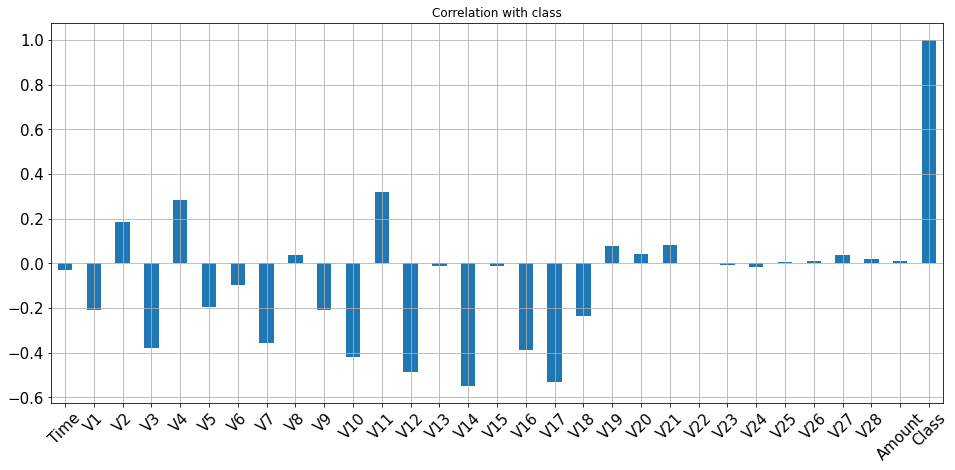

In [15]:
corr = df.corrwith(df.Class).plot.bar(
    figsize = (16, 7), 
    title = "Correlation with class",
    fontsize = 15,
    rot = 45,
    grid = True
)

In [16]:
corr = df.corr()

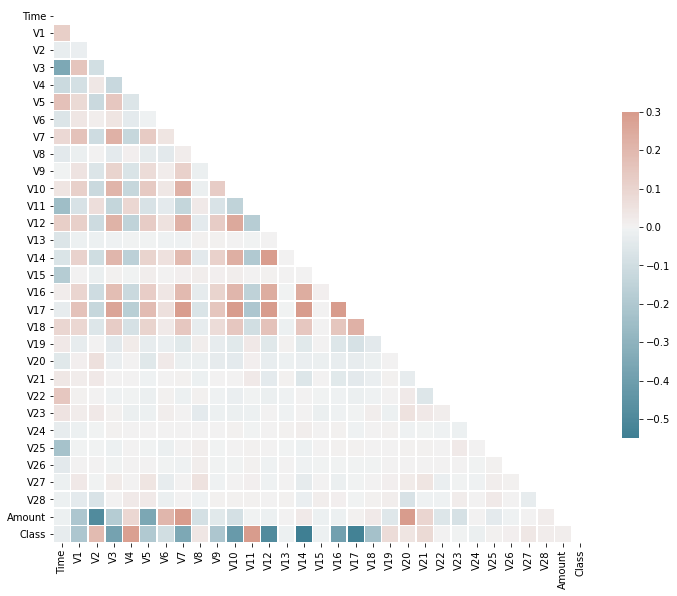

In [17]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(220.0, 10.0, as_cmap=True)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, mask=mask, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

## <font color='darkblue'>Feature Scaling</font>
<b>Bringing features onto the same scale Feature scaling is a crucial step in our preprocessing pipeline that can easily be forgotten.</b> Decision trees and random forests are one of the very few machine learning algorithms where we don’t need to worry about feature scaling. However, the majority of machine learning and optimization algorithms behave much better Using standardization, <b>we center the feature columns at mean 0 with standard deviation 1 so that the feature columns take the form of a normal distribution, which makes it easier to learn the weights.</b> Furthermore, standardization maintains useful information about outliers and makes the algorithm less sensitive to them in contrast to min-max scaling, which scales the data to a limited range of values.


### <font color='darkgreen'>Standardization</font>
The procedure of standardization can be expressed by the following equation:
![standarization](images/1.PNG)

In [ ]:
from sklearn.preprocessing import StandardScaler
X_no_time['normalizedAmount'] = StandardScaler().fit_transform(X_no_time['Amount'].values.reshape(-1,1))
X_no_time = X_no_time.drop(['Amount'],axis=1)
X_no_time.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,anomaly_scores,Amount_max_fraud,V1_,V2_,V3_,V4_,V5_,V6_,V7_,V9_,V10_,V11_,V12_,V14_,V16_,V17_,V18_,V19_,V21_,normalizedAmount
0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,3.202033,-2.899907,-0.595222,-4.289254,0.389724,-1.140747,-2.830056,-0.016822,0.416956,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.060981,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.364533
1,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,-0.414575,-0.503141,0.676502,-1.692029,2.000635,0.666780,0.599717,1.725321,0.283345,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,0.027649,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.787919
2,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,2.032912,-6.560124,0.022937,-1.470102,-0.698826,-2.282194,-4.781831,-2.615665,-1.334441,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,0.072677,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.611720
3,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,4.895844,-10.912819,0.184372,-6.771097,-0.007326,-7.358083,-12.598419,-5.131549,0.308334,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,0.162471,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,-0.124467
4,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,2.101344,-4.609628,1.464378,-6.079337,-0.339237,2.581851,6.739384,3.042493,-2.721853,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,0.189563,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,-0.360464


### <font color='darkgreen'>Test/Train Split</font>
Then is to split the dataset into training/testing parts:

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_no_time, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,anomaly_scores,Amount_max_fraud,V1_,V2_,V3_,V4_,V5_,V6_,V7_,V9_,V10_,V11_,V12_,V14_,V16_,V17_,V18_,V19_,V21_
50063,0.900406,-0.863693,-1.896791,-3.818247,1.859415,3.227005,-1.102975,-0.115656,-2.040139,1.093269,-0.328706,-0.975692,0.112287,0.136313,-0.181185,-0.383130,-0.017400,-0.126132,-1.472773,-0.617517,0.889091,0.422764,-0.086092,0.710982,0.197044,-0.084990,0.290601,0.315750,0.01,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
607,-0.816727,0.594614,-1.962802,0.928670,-1.165681,0.712386,3.791480,-0.520172,-1.251007,0.064204,0.633326,0.579913,0.563453,0.887776,-0.344560,-0.394735,-0.569965,0.416375,0.786350,0.116912,0.265684,1.171538,0.484236,-0.360965,-0.621692,-0.533384,0.368966,-0.129636,612.00,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9165,2.191849,-1.690885,-0.672327,-1.749958,-1.362611,0.187211,-1.605726,0.215670,-0.986033,1.704791,0.180897,-0.953688,-1.017155,-0.122388,-0.345921,0.104663,0.110111,0.588641,0.234215,-0.427024,-0.378045,-0.815557,0.442154,0.178572,-0.647633,-0.506235,0.016533,-0.040560,42.97,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22664,-8.812048,7.270034,-7.244796,0.653928,-4.837097,-1.250350,-5.004864,6.856003,-0.822632,1.082842,-0.863603,3.562482,1.395598,4.635715,-0.185894,1.100192,2.285512,0.342317,-0.004690,-0.215260,0.479860,0.351238,1.037277,-0.334499,0.278195,-0.319353,-0.499615,-0.109271,0.89,0.095541,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
27375,-0.432971,0.216588,3.163865,-0.002076,0.605612,1.040385,1.296295,-1.576744,1.846744,2.194101,0.679918,-1.093678,-1.646581,-1.903498,0.380454,-0.565301,-1.109691,0.718542,1.812648,0.492835,-0.321130,0.217767,-0.524052,-0.491494,-0.578110,0.264374,-2.170597,-1.665200,14.00,0.028878,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


###  <font color='darkgreen'>Upsampling</font>
In order to have balanced data, here we apply upsampling method:

In [19]:
from imblearn.over_sampling import RandomOverSampler, ADASYN, BorderlineSMOTE, SVMSMOTE

upsampling_model = SVMSMOTE(random_state=RANDOM_STATE, sampling_strategy = SAMPLING_STRATEGY)

In [20]:
X_train_us, y_train_us = upsampling_model.fit_sample(X_train, y_train)

In [21]:
print(f"Minority Class: {y_train[y_train['Class']==1].shape[0]} -> {y_train_us[y_train_us['Class']==1].shape[0]}")

Minority Class: 417 -> 2416


c:\users\johnlee\appdata\local\programs\python\python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


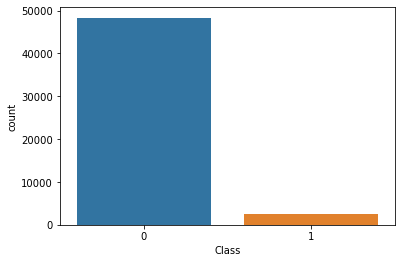

In [22]:
# The size of minority is 324. So we reduce the size of majority to 324 too
sns.countplot(y_train_us['Class'])

## <font color='darkblue'>Model Training</font>

### <font color='darkgreen'>Decision tree</font>
[**Decision trees**](https://en.wikipedia.org/wiki/Decision_tree) are statistical data mining technique that express independent attributes and a dependent attributes logically AND in a tree shaped structure. Classification rules, extracted from decision trees, are IF-THEN expressions and all the tests have to succeed if each rule is to be generated. Decision tree usually separates the complex problem into many simple ones and resolves the sub problems through repeatedly using .Decision trees are predictive decision support tools that create mapping from observations to possible consequences. There are number of popular classifiers construct decision trees to generate class models. Decision tree methods C5.0 ,C&RT and CHAID.

In [ ]:
## Decison Tree
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(random_state = RANDOM_STATE,
                                    criterion = 'gini',  splitter='best', min_samples_leaf=1, min_samples_split=2)
classifier.fit(X_train, y_train)
# Predicting Test Set
y_pred = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
results = pd.DataFrame([['Decision tree', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

### <font color='darkgreen'>Random forests</font>
Random forest model is an ensemble of classification (or regression) trees.The popularity of decision tree models in data mining arises from their ease of use, flexibility in terms of handling various data attribute types, and interpretability. <b><font color='darkred'>Single tree models, however, can be unstable and overly sensitive to specific training data.</font></b>

<b>Ensemble methods seek to address this problem by developing a set of models and aggregating their predictions in determining the class label for a data point.</b> Random forests are computationally efficient since each tree is built independently of the others. With large number of trees in the ensemble, they are also noted to be robust to over fitting and noise in the data.

In [ ]:
## Randomforest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
classifier = RandomForestClassifier(random_state = RANDOM_STATE, n_estimators = 100,
                                    criterion = 'entropy')
classifier.fit(X_train, y_train)
# Predicting Test Set
y_pred = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
model_results = pd.DataFrame([['Random Forest (n=100)', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
results = results.append(model_results, ignore_index = True)
results

c:\users\johnlee\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


,Model,Accuracy,Precision,Recall,F1 Score
0,Decision tree,0.996513,0.816901,0.773333,0.794521
1,Random Forest (n=100),0.998257,0.983871,0.813333,0.890511


## <font color='darkblue'>Artificial Neural Network Model</font>
<b>Fraud detection methods based on neural network are the most popular ones.</b> An artificial neural network consists of an interconnected group of artificial neurons .The principle of neural network is motivated by the functions of the brain especially pattern recognition and associative memory. 

The neural network recognizes similar patterns, predicts future values or events based upon the associative memory of the patterns it was learned. It is widely applied in classification and clustering. <b>The advantages of neural networks over other techniques are that these models are able to learn from the past and thus, improve results as time passes.</b> They can also extract rules and predict future activity based on the current situation. By employing neural networks, effectively, banks can detect fraudulent use of a card, faster and more efficiently.

<b>Among the reported credit card fraud studies most have focused on using neural networks.</b> In more practical terms neural networks are non-linear statistical data modeling tools. They can be used to model complex relationships between inputs and outputs or to find patterns in data. There are two phases in neural network training and recognition. Learning in a neural network is called training. There are two types of NN training methods supervised and unsupervised.

In supervised training, samples of both fraudulent and non fraudulent records are used to create models. In contrast, unsupervised training simply seeks those transactions, which are most dissimilar from the norm. On other hand, the unsupervised techniques do not need the previous knowledge of fraudulent and non fraudulent transactions in database. <b>NNs can produce best result for only large transaction dataset. And they need a long training dataset.</b>

In [23]:
import keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [24]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras.optimizers import SGD
from keras.layers import Dropout

# Initialising the ANN
classifier = Sequential()

# Adding the dropout layer
classifier.add(Dropout(0.05, input_shape=(X_train.shape[1],)))

# Adding the input layer and the first hidden layer
classifier.add(Dense(X_train.shape[1], kernel_initializer='uniform', activation='relu'))


# Adding the second hidden layer
classifier.add(Dense(units=17, kernel_initializer = 'uniform', activation = 'relu', activity_regularizer=regularizers.l1(10e-4)))

#classifier.add(Dense(units = 16, 
#                     kernel_initializer='uniform',
#                     activation='relu',
#                     activity_regularizer=regularizers.l1(10e-5)))


# Adding the third hidden layer
r'''
classifier.add(Dropout(0.01))
classifier.add(Dense(
                        units=7, 
                        kernel_initializer='uniform',
                        activation = 'relu',
                        activity_regularizer=regularizers.l1(10e-4)
                    )
)
'''


# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
# https://keras.io/api/optimizers/
# opt = SGD(lr=0.01, momentum=0.9)
m_preccision = keras.metrics.Precision()
m_recall = keras.metrics.Recall()
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [m_preccision, m_recall])
# classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print(classifier.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 48)                0         
_________________________________________________________________
dense (Dense)                (None, 48)                2352      
_________________________________________________________________
dense_1 (Dense)              (None, 17)                833       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 18        
Total params: 3,203
Trainable params: 3,203
Non-trainable params: 0
_________________________________________________________________
None


Start training

In [26]:
# Fitting the ANN to the Training set
BATCH_SIZE=32
EPOCHS = 10
history = classifier.fit(X_train_us, y_train_us, batch_size = BATCH_SIZE, epochs = EPOCHS)

Epoch 1/10
1586/1586 [==============================] - 14s 9ms/step - loss: 0.0148 - precision: 0.9851 - recall: 0.9603
Epoch 2/10
1586/1586 [==============================] - 12s 7ms/step - loss: 0.0137 - precision: 0.9852 - recall: 0.9632
Epoch 3/10
1586/1586 [==============================] - 13s 8ms/step - loss: 0.0137 - precision: 0.9831 - recall: 0.9652
Epoch 4/10
1586/1586 [==============================] - 15s 10ms/step - loss: 0.0134 - precision: 0.9869 - recall: 0.9648
Epoch 5/10
1586/1586 [==============================] - 15s 10ms/step - loss: 0.0134 - precision: 0.9840 - recall: 0.9656
Epoch 6/10
1586/1586 [==============================] - 16s 10ms/step - loss: 0.0133 - precision: 0.9843 - recall: 0.9627
Epoch 7/10
1586/1586 [==============================] - 15s 9ms/step - loss: 0.0134 - precision: 0.9852 - recall: 0.9640
Epoch 8/10
1586/1586 [==============================] - 15s 10ms/step - loss: 0.0130 - precision: 0.9861 - recall: 0.9656
Epoch 9/10
1586/1586 [======

In [27]:
classifier.save(SERIALIZED_MODEL_FILE)
loaded_classifier = keras.models.load_model(SERIALIZED_MODEL_FILE)

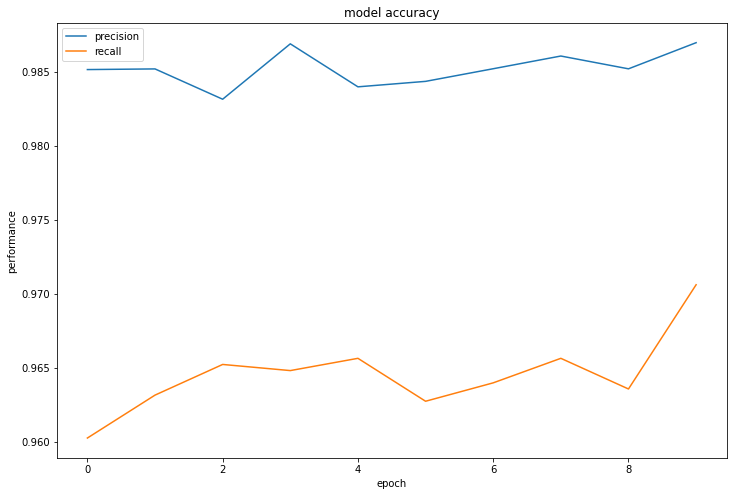

In [28]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.plot(history.history['precision'])
plt.plot(history.history['recall'])
plt.title('model accuracy')
plt.ylabel('performance')
plt.xlabel('epoch')
plt.legend(['precision', 'recall'], loc='upper left')
plt.show()

Making prediction on testing dataset:

In [29]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)
score = classifier.evaluate(X_test, y_test)
score

269/269 [==============================] - 2s 8ms/step - loss: 0.0144 - precision: 0.9385 - recall: 0.8133


[0.014423978514969349, 0.9384615421295166, 0.8133333325386047]

In [31]:
y_pred = classifier.predict(X_test)
y_pred.shape

(8604, 1)

## <font color='darkblue'>Evaluation</font>


### <font color='darkgreen'>Confusion matrix</font>
Well, [**Confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix) is a performance measurement for machine learning classification problem where output can be two or more classes. It is a table with 4 different combinations of predicted and actual values:
![confusion matrix](images/2.PNG)
<br/>

In [ ]:
#Let's see how our model performed
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
y_pred = y_pred.round()
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model_results = pd.DataFrame([[f'ANN ({EPOCHS})', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

results = results.append(model_results, ignore_index = True)
results

Visualization of confusion matrix

In [ ]:
## EXTRA: Confusion Matrix
cm = confusion_matrix(y_test, y_pred) # rows = truth, cols = prediction
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g')
tp = tn = fp = fn = 0
for a, p in zip(y_test.Class.tolist(), y_pred.reshape((1, -1)).tolist()[0]):
    if a and p:
        tp += 1
    elif a and not p:
        fn += 1
    elif not a and not p:
        tn += 1
    else:
        fp += 1

precision= tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
        
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))
print(f"Precision={precision:.02f}")
print(f"Recall={recall:.02f}")
print(f"F1={f1:.02f}")

ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let’s have a look at our ROC curve:

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_pred_keras = classifier.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_keras)

In [ ]:
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

XGBoost

In [ ]:
from xgboost import XGBClassifier

clf = XGBClassifier(scale_pos_weight=1, random_state=RANDOM_STATE)
%time clf.fit(X_train, y_train)

In [ ]:
# Prediction
Y_Test_Pred = clf.predict(X_test)

In [ ]:
# Confusion matrix
pd.crosstab(Y_Test_Pred, y_test['Class'], 
            rownames=['Predicted'], colnames=['Actual'])

In [ ]:
acc, prec, rec, f1 = generate_model_report(y_test, Y_Test_Pred)
model_results = pd.DataFrame([['XGBoost', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

results = results.append(model_results, ignore_index = True)
results

The ROC curve plots the true positive rate versus the false positive rate, over different threshold values. <b>Basically, we want the blue line to be as close as possible to the upper left corner.</b> While our results look pretty good, we have to keep in mind of the nature of our dataset. 

### <font color='darkgreen'>PR chart</font>
Another way to evaluate model is to look at [P/R chart](http://mlwiki.org/index.php/Precision_and_Recall) (Precision/Recall curve):

In [37]:
y_test['Class'].shape

(8604,)

lr_probs.shape=(8604, 1)
Logistic: f1=0.871 auc=0.870


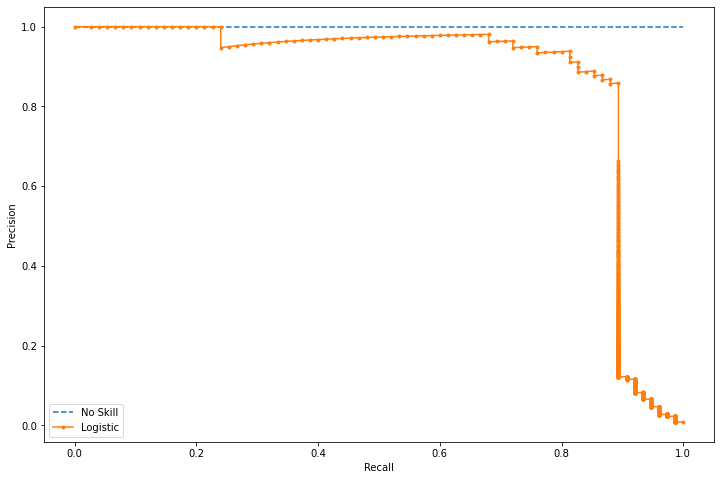

In [40]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

lr_probs = classifier.predict(X_test)
y_pred = (lr_probs > 0.5)
lr_precision, lr_recall, _ = precision_recall_curve(y_test['Class'], lr_probs)

lr_f1 =  f1_score(y_test['Class'], y_pred)
lr_auc = auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(X_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

## <font color='darkblue'>Conclusions</font>
Credit card fraud has become more and more rampant in recent years. To improve merchants risk management level in an automatic and effective way, building an accurate and easy handling credit card risk monitoring system is one of the key tasks for the merchant banks.

<b>One aim of this study is to identify the user model that best identifies fraud cases.</b> There are many ways of detection of credit card fraud. If one of these or combination of algorithm is applied into bank credit card fraud detection system, the probability of fraud transactions can be predicted soon after credit card transactions by the banks. And a series of anti-fraud strategies can be adopted to prevent banks from great losses before and reduce risks.

## <font color='darkblue'>Supplement</font>
* [How to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
* [Python如何為Keras分類器生成ROC曲線的簡單指南](https://kknews.cc/zh-tw/code/bg3onl9.html)
* [How to add function (Get F1-score) in Keras metrics and record F1 value after each epoch?](https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d)
* [6 Types of Artificial Neural Networks Currently Being Used in Machine Learning](https://analyticsindiamag.com/6-types-of-artificial-neural-networks-currently-being-used-in-todays-technology/)
> Artificial neural networks are computational models that work similarly to the functioning of a human nervous system. There are several kinds of artificial neural networks. These types of networks are implemented based on the mathematical operations and a set of parameters required to determine the output.

* [Simple guide on how to generate ROC plot for Keras classifier](https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/)
* [Keras - Plot training, validation and test set accuracy](https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy)
* [保存和加載Keras模型](https://www.tensorflow.org/guide/keras/save_and_serialize)
* [機器學習ML NOTE - SGD, Momentum, AdaGrad, Adam Optimizer](https://medium.com/%E9%9B%9E%E9%9B%9E%E8%88%87%E5%85%94%E5%85%94%E7%9A%84%E5%B7%A5%E7%A8%8B%E4%B8%96%E7%95%8C/%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92ml-note-sgd-momentum-adagrad-adam-optimizer-f20568c968db)
* [Your First Deep Learning Project in Python with Keras Step-By-Step](https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/)
* [第16章 使用Dropout正则化防止过拟合](https://cnbeining.github.io/deep-learning-with-python-cn/4-advanced-multi-layer-perceptrons-and-keras/ch16-reduce-overfitting-with-dropout-regularization.html)
> Dropout虽然简单，但可以有效防止过拟合。本章关于如何在Keras中使用Dropout